## King County House Sales Project Submission

Please fill out:
* Student names: Andrew Boucher, Jon McCaffrey
* Student pace: full time
* Scheduled project review date/time: 10/28/22 15:00 EST
* Instructor name: Daniel Burdeno



In [2]:
# Your code here - remember to use markdown cells for comments as well!

# Overview

For this project, we will be using multiple linear regression modeling to analyze house sales in King County, WA, based on data from May 2014 - May 2015.

# Business Challenge

We will be presenting to a home building and renovation company __[Northwest Builders & Renovation](northwestbnr.com)__ in Seattle, WA.  The premise is they are looking for insight into what features of properties have the greatest impact on sale price.  This information could influence what clients they market to for potential renovation projects as well as what features are most important to consider for new home construction.  

# Data Understanding

## Initial imports

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import time as time
!pip install haversine
import haversine as hs

## Loaded data, initial exploratory data analysis

We will be transforming our initial dataframe multiple times throughout this notebook.  Here is an initial outline of the process to create our ultimate model from the dataset, with more detail to follow at each step.  Please refer back to this cell if needed to review the process.
- df = initial dataframe
- df2 = adding a timestamp column.  This will be relevant for subsetting resale properties later.
- df3 = adding distance to downtown Seattle, in miles, based on each location's latitude & longitude
- df4 = creating separate smaller dataframe with only the column for "condition", prior to ordinal encoding
- df5 = the dataframe for "condition" after ordinal encoding
- df6 = concatenating ordinal-encoded "condition" back together with main dataframe (df3 at this point)
- df7 = creating a dataframe of only "numeric" data types
- df8 = removing irrelevant or misleading numeric qualities
- df9 = removing top ~2% of outliers for sqft_lot15 column
- df10 = removing top ~2% of outliers for price.  This is the dataframe our main multiple regression model is modeled on.  

In [4]:
# establishing initial dataframe
df = pd.read_csv('.\data\kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
# checking size of initial dataframe
df.shape

(21597, 21)

In [7]:
# Exploring the data types and quantities for each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Some of the features above may require an alteration in data type for better evaluation as either a continuous or discrete variable, for potentially fitting to our model.
- date: entered as a string in the dataframe
- zipcode: entered as a numeric but may be more suitable to consider as a discrete / categorical variable
- grade: may require one hot encoding, or ordinal encoding, for comparison as a numeric
- condition: may require ordinal encoding for comparison as a numeric

We eventually chose "condition" as one categorical feature to explore, partially to avoid adding too many more features with one hot encoding or ordinal encoding ALL categorical variables, and we will explain why we it was the most relevant categorical feature for us to explore.  

As an example, to illustrate value counts we would have to consider with multiple categorical features to transform:

In [114]:
len(df['zipcode'].value_counts()), len(df['view'].value_counts()), len(df['waterfront'].value_counts()), len(df['grade'].value_counts())

# the number of zipcodes, "view" categories, "waterfront" categories (yes/no), and "grade" categories:

(70, 5, 2, 11)

In [9]:
# obtaining statistics for numeric columns
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Noted likely outliers for price, bedrooms and sqft_lot15, based on the wide margins between the 75th percentile and the max quantity entered.  Will address below

In [10]:
# checking for null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Note a large amount of nulls in the "waterfront" column and the "yr_renovated" columns, which will influence our decision whether or not to include them in our final model.  

In [11]:
# looking at correlation for numeric portion of dataframe
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


That's a lot of information to absorb.  Here's an annotated visual to make it a *little* easier to read

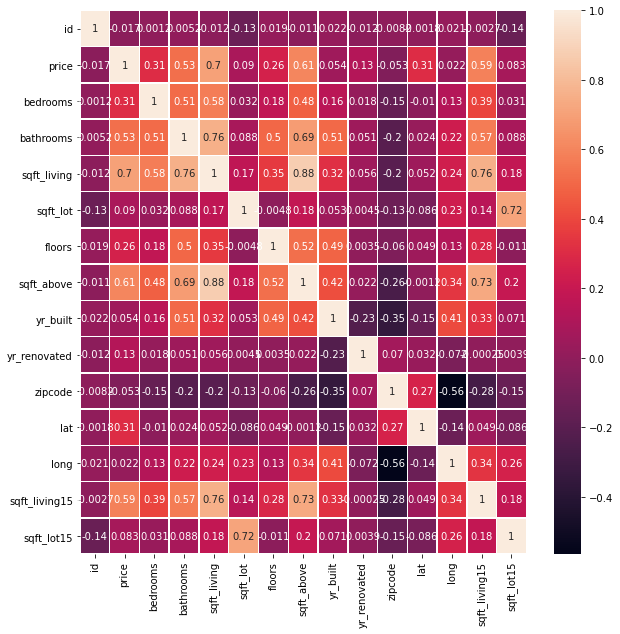

In [12]:
# producing a heatmap of correlations
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax);

We want to include as many numeric features as we can and would like to include as many relevant categorical features as well to improve our model.  We can highlight the significant correlations to our target category "price" below, as most will be included in our future modeling:

In [115]:
df.corr()['price']

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
sqft_above       0.605368
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Name: price, dtype: float64

We can put those values in descending order, and looking at absolute values, below:

In [116]:
df.corr()['price'].map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
zipcode          0.053402
long             0.022036
id               0.016772
Name: price, dtype: float64

This is where it starts to become apparent which features may have the greatest impact on our target "price", but we will have to consider the quality of the data, potential multicollinearity, or simply overlap in what each feature is representing.  

# Data Preparation

## Create a new column that converts date into a time stamp

In [13]:
# df2 - added timestamp
# creating new column that converts date into a time stamp which is the 
# number of seconds since 1/1/1970 (aka UTC)
df2 = df.copy()
df2['time_stamp'] = [time.mktime(time.strptime(x, '%m/%d/%Y')) for x in df['date']]
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09


In [14]:
# sanity check to ensure only one column was added to original dataframe
df2.shape

(21597, 22)

# Creating a new dataframe with column for distance from downtown Seattle

Rather than focus on latitude and longitude separately, or try to utilize the zipcode (which represent areas of vastly different size in no particular ordinal way) we elected to create one numeric column that will represent the distance of each location in the dataframe from a point in downtown Seattle (provided by a __[Google](https://www.google.com/search?q=downtown+Seattle+latitude+longitude&source=lmns&bih=736&biw=888&hl=en&sa=X&ved=2ahUKEwi-95SOmYP7AhUGmVMKHf0lAsIQ_AUoAHoECAEQAA)__ search)

In [15]:
# initializing and formatting location variables
# loc 1 equals lat/long of each house in dataset
# loc 2 equals defined lat/long of Seattle from Google
loc1 = list(zip(df2['lat'], df2['long']))
loc2 = (47.6050, -122.3344)

In [16]:
# df3 - created new column to convert lat/long to distance from downtown Seattle
# in miles
df3 = df2.copy()
df3['dist_Seattle'] = [hs.haversine((x,y), loc2, unit='mi') for x,y in loc1]
df3.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp,dist_Seattle
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09,7.418041
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09,8.046810
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09,10.323554
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09,6.427255
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09,13.504920


In [17]:
# confirming only one more column added
df3.shape

(21597, 23)

# Creating a new dataframe with column for ordinal-encoded condition

## Why only the "condition" column?

To recap the potential discrete variables that we would incorporate at this point, we could include "waterfront", "view", "grade", or "condition".

The "waterfront" column is a binary of YES/NO and has 2,376 nulls, as well as a vast majority of NO responses

In [117]:
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

The "view" column has 5 values, but NONE is the vast majority in that column

In [119]:
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

The "grade" column seemed promising, based on the variety of respones.

In [123]:
df['grade'].value_counts().sort_values(ascending=False)

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

We one hot encoded the "grade" column and, unsurprisingly, the highest grades are positively correlated with price.  We did notice 'Average' is slightly negatively correlated and yet 'Better' is positively correlated.  

In [124]:
df_price_grade = pd.concat([df['price'], df['grade']], axis=1)

In [125]:
dummy_price_grade = pd.get_dummies(df_price_grade, drop_first=True)

In [126]:
dummy_price_grade.corr()['price']

price                  1.000000
grade_11 Excellent     0.357589
grade_12 Luxury        0.291068
grade_13 Mansion       0.211806
grade_3 Poor          -0.005155
grade_4 Low           -0.031618
grade_5 Fair          -0.084549
grade_6 Low Average   -0.209463
grade_7 Average       -0.316053
grade_8 Good           0.004576
grade_9 Better         0.235859
Name: price, dtype: float64

What would it take for a home to bump from average to better?  Was that worth pursuing?  The more we read ( __[1](https://www.sapling.com/12067706/grade-mean-tax-assessment#:~:text=Grade%20is%20an%20evaluation%20of%20the%20construction%20materials,Entry-level%20appraisers%20usually%20make%20the%20initial%20grade%20estimate.)__ __[2](https://budgeting.thenest.com/difference-value-appraisal-good-vs-average-23510.html)__ ) about a house's "grade" however, the more we realized it has to do with its original construction and not with renovations.  And though our client does do new homebuilding, they are not in the market of building high-end homes at this time.

So now we'll explore "condition" as an option for a categorical variable to investigate its influence on sale price and possible practical value for our client. Based on above reading on grade as well, the "condition" feature appears to be a subjective rating applied in real estate appraisals.  
Looking below, there seems to be an adequate variety of values.  

In [127]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [18]:
# ordinal encoding condition
categories = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]
ords = OrdinalEncoder(categories=categories)

In [19]:
# df4 - create dataframe of only 'condition'
df4 = pd.DataFrame(df3['condition'])

In [20]:
# fit to ordinal encoder and transform
ords.fit(df4)
cond = ords.transform(df4)
cond

array([[2.],
       [2.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]])

In [21]:
# df5 - new dataframe with ordinal encoding taking place of grade
df5 = pd.DataFrame(cond, df4.index, columns=['ord_cond'])
# reset df5 dataframe to index of df4

In [22]:
df4.value_counts()

condition
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
dtype: int64

In [23]:
df5.value_counts()

ord_cond
2.0         14020
3.0          5677
4.0          1701
1.0           170
0.0            29
dtype: int64

In [24]:
# df6 - concatenate df3 and df5 (ordinal encoded condition)
df6 = pd.concat([df3, df5], axis=1)
df6.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09,13.504920,2.0


In [25]:
df6.shape

(21597, 24)

## Trimming dataframe to remove what we've decided are not the most relevant categorical and numeric features

In [26]:
# df7 - creating dataframe with only numeric columns
df7 = df6.select_dtypes(include='number')
df7.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09,13.504920,2.0


We will remove "yr_renovated" before modeling due to the very high null count (3,842)

In [130]:
df['yr_renovated'].isna().sum()

3842

We will also remove the numeric values of "zipcode", "lat", and "long" in favor of using the distance to downtown Seattle value we've created ("dist_Seattle")

In [27]:
# df8 - created dataframe with only relevant numerics included
df8 = df7.drop(['yr_renovated', 'zipcode', 'lat', 'long'], axis=1)

In [28]:
df8.shape

(21597, 14)

In [29]:
df8.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


## Investigating for Outliers

Revisiting the original dataframe (df) we will highlight some potential outliers to consider removing prior to data modeling

In [131]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


We'll highlight the max value for "bedrooms" below, then calculate the IQR for "sqft_lot15" and "price" and compare 1.5xIQR above the 75th percentile to the highest values in those features. 

### Outlier in Bedrooms

In [32]:
df8['bedrooms'].value_counts()
# reveals one house with '33' bedrooms

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [33]:
beds_outlier = df8.loc[df8['bedrooms'] > 11]
beds_outlier
# looks like the number '3' entered twice by mistake.  Will impute to '3'

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,1040,1947,1330,4700,1.403669e+09,5.723124,4.0


In [34]:
# Imputing 33 to 3
df8['bedrooms'] = df8['bedrooms'].replace([33], 3)

In [35]:
# checking that it's gone
df8['bedrooms'].describe()

count    21597.000000
mean         3.371811
std          0.904096
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

### Outliers in sqft_lot15

We'll review the "sqft_lot15" category, then calculate IQR and see how many outliers we would remove if we go 1.5xIQR above the 75th percentile.  

In [36]:
df8['sqft_lot15'].describe()
# large difference between max and 75%

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

In [37]:
# freezing sqlot_15 mean and std
rvs_sqft_lot15 = stats.norm(loc=df8['sqft_lot15'].mean(), scale=df8['sqft_lot15'].std())

In [38]:
# calculating interquartile range for sqft_lot15
IQR_sqft_lot15 = rvs_sqft_lot15.ppf(0.75) - rvs_sqft_lot15.ppf(0.25)
IQR_sqft_lot15

36792.663075707234

In [39]:
# calculating outliers via IQR range
upper_sqft_lot15 = rvs_sqft_lot15.ppf(0.75) + (1.5*IQR_sqft_lot15)
upper_sqft_lot15

86343.6096630133

In [40]:
lower_sqft_lot15 = rvs_sqft_lot15.ppf(0.25) - (1.5*IQR_sqft_lot15)
lower_sqft_lot15
# this yields a negative number, 
# so we won't be eliminating any values at the lower end of sqft_lot15 data

-60827.042639815634

In [41]:
# df9 - creating a dataframe with sqft_lot15 values 
# above the upper_sqft_lot15 threshold removed
df9 = df8.drop(df8[df8['sqft_lot15'] >= upper_sqft_lot15].index)

In [42]:
df9.shape

(21190, 14)

In [43]:
len(df8) - len(df9)

407

In [44]:
407 / len(df8)

0.01884520998286799

- That would remove 1.9% of values from df8

## Removing price outliers

We can see some exceptionally highly priced homes in a table just by noticing a doubling in sale price just in the top 25 highest-priced homes

In [146]:
df9['price'].sort_values(ascending=False).head(25)

7245     7700000.0
3910     7060000.0
9245     6890000.0
4407     5570000.0
1446     5350000.0
1313     5300000.0
1162     5110000.0
8085     4670000.0
2624     4500000.0
8629     4490000.0
12358    4210000.0
4145     4000000.0
2083     3850000.0
7028     3800000.0
19002    3800000.0
16288    3710000.0
18467    3650000.0
6502     3650000.0
15241    3640000.0
19133    3640000.0
2862     3600000.0
21560    3570000.0
5874     3420000.0
13954    3400000.0
10435    3400000.0
Name: price, dtype: float64

Here is a visual to show the skew of the outliers.

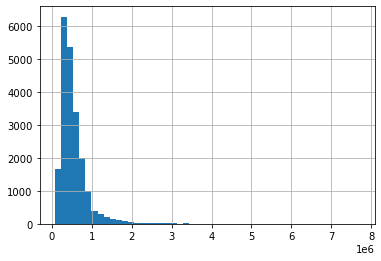

In [45]:
# quick histogram to visualize potential skewness
df9['price'].hist(bins=50);

We can also see mean value (539,000) is much higher than the median value (450,000).  

In [147]:
df9['price'].mean(), df9['price'].median()

(538707.2870221803, 450000.0)

Let's calculate IQR and see how many outliers we would remove if we go 1.5xIQR above the 75th percentile.  

In [46]:
# freezing price mean and std
rvs_price = stats.norm(loc=df9['price'].mean(), scale=df9['price'].std())

In [47]:
# calculating interquartile range for price
IQR_price = rvs_price.ppf(0.75) - rvs_price.ppf(0.25)
IQR_price

495874.44485276565

In [48]:
# calculating outliers via IQR range
upper_price = rvs_price.ppf(0.75) + (1.5*IQR_price)
upper_price

1530456.1767277117

In [49]:
lower_price = rvs_price.ppf(0.25) - (1.5*IQR_price)
lower_price
# this yields a negative number, so we won't be eliminating any values at the lower end of price data

-453041.602683351

In [50]:
# df10 - creating a dataframe with price values above the upper_price 
# threshold removed
df10 = df9.drop(df9[df9['price'] >= upper_price].index)

In [51]:
df10.shape

(20706, 14)

In [52]:
len(df9) - len(df10)

484

In [53]:
484 / len(df9)

0.02284096271826333

- So we removed 2.3% of data points based on high price outliers

# Modeling

## Creating model based on highest correlations to price from the dataframe without removing sqft_lot15 OR price outliers (df8)

In [54]:
# check shape
df8.shape

(21597, 14)

In [55]:

df8.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


In [148]:
# we'll remove numeric values of "id" (meaningless numeric for model) and 
# "price" since that will be our target
df8drop = df8.drop(['id', 'price'], axis=1)

In [57]:
# scaling for model
ss_df8 = StandardScaler().fit(df8drop)
df8_scaled = ss_df8.transform(df8drop)

In [149]:
# creating a dataframe for scaled data to retain column names later 
# in model summary
df8_scaled = pd.DataFrame(df8_scaled, columns=df8drop.columns)

In [59]:
# establishing endog & exog
x0 = sm.add_constant(df8_scaled)
y0 = df8['price'].reset_index(drop=True)

In [60]:
model0 = sm.OLS(endog=y0, exog=x0).fit()

In [61]:
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     3363.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:48:43   Log-Likelihood:            -2.9601e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:                   21584   BIC:                         5.921e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.403e+05   1476.049    366.043      0.000    5.37e+05    5.43e+05
bedrooms       -5.49e+04   1892.506    -29.007      0.000   -5.86e+04   -5.12e+04
bathrooms      4.294e+04   2679.775     16.023      0.000    3.77e+04    4.82e+04
sqft_living    1.806e+05   4209.955     42.902      0.000    1.72e+05    1.89e+05
sqft_lot       1.274e+04   2137.783      5.959      0.000    8548.528    1.69e+04
floors        -4222.8652   2101.709     -2.009      0.045   -8342.369    -103.361
sqft_above     5.838e+04   3814.646     15.305      0.000    5.09e+04    6.59e+04
yr_built      -3.835e+04   2141.605    -17.906      0.000   -4.25e+04   -3.41e+04
sqft_living15  6.502e+04   2348.636     27.682      0.000    6.04e+04    6.96e+04
sqft_lot15     -928.6516   2161.273     -0.430      0.667   -5164.906    3307.603
time_stamp     1.227e+04   1480.065      8.287      0.000    9364.521    1.52e+04
dist_Seattle  -1.247e+05   1787.021    -69.769      0.000   -1.28e+05   -1.21e+05
ord_cond        2.26e+04   1616.586     13.980      0.000    1.94e+04    2.58e+04
==============================================================================
Omnibus:                    17883.052   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1336079.612
Skew:                           3.517   Prob(JB):                         0.00
Kurtosis:                      40.885   Cond. No.                         7.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

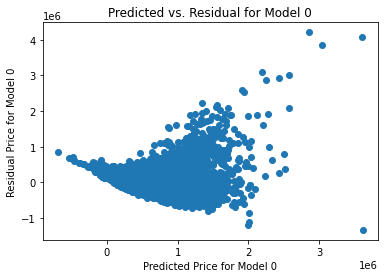

In [62]:
# predicted vs. residual
preds0 = model0.predict(x0)
resids0 = y0 - preds0

plt.plot(preds0, resids0, "o")
plt.xlabel('Predicted Price for Model 0')
plt.ylabel('Residual Price for Model 0')
plt.title('Predicted vs. Residual for Model 0');

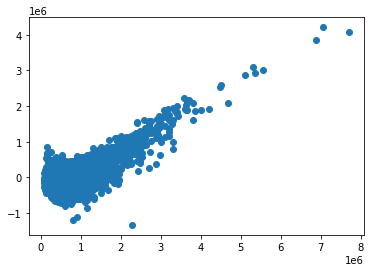

In [63]:
# checking for independence and homoskedasticity
# independence appears linear, and higher values do appear homoskedastic
fig, ax = plt.subplots()
ax.scatter(y0, resids0);

In [64]:
# ideal Durbin-Watson is 2 for independence 
model0.summary().tables[2]

Omnibus:,17883.052,Durbin-Watson:,2.001
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1336079.612
Skew:,3.517,Prob(JB):,0.00
Kurtosis:,40.885,Cond. No.,7.61


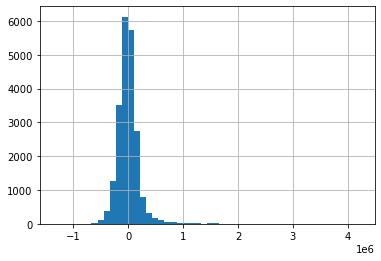

In [65]:
# creating histogram of residuals (errors) to check if errors are 
# normally distributed, which it appears to be

resids0.hist(bins=50);

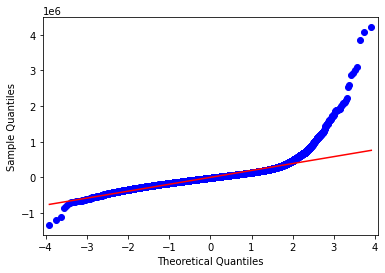

In [66]:
# QQ plot is another means for assessing for normality of errors
# We note the errors follow the line closely until the end  
sm.qqplot(resids0, line='r');

In [67]:
# We want a smaller Jarque-Bera, and prob(JB) > 0.05
# We also want a small Omnibus number, as well as Skew & Kurtosis
# Condition number already appears in a safe range, and therefore
# we do not appear to have a significant amount of multicollinearity 
# between the features
model0.summary().tables[2]

Omnibus:,17883.052,Durbin-Watson:,2.001
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1336079.612
Skew:,3.517,Prob(JB):,0.00
Kurtosis:,40.885,Cond. No.,7.61


# Summary 
- what's good already
- but what may be improved with additional modeling

## Creating model based on highest correlations to price with dataframe with all prices included BUT sqft_lot15 outliers removed (df9)

In [68]:
df9.shape

(21190, 14)

In [69]:
df9.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


In [70]:
df9drop = df9.drop(['id', 'price'], axis=1)

In [71]:
ss_df9 = StandardScaler().fit(df9drop)
df9_scaled = ss_df9.transform(df9drop)

In [72]:
df9_scaled = pd.DataFrame(df9_scaled, columns=df9drop.columns)

In [73]:
x1 = sm.add_constant(df9_scaled)
y1 = df9['price'].reset_index(drop=True)

In [74]:
model1 = sm.OLS(endog=y1, exog=x1).fit()

In [75]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3309.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:48:44   Log-Likelihood:            -2.9042e+05
No. Observations:               21190   AIC:                         5.809e+05
Df Residuals:                   21177   BIC:                         5.810e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.387e+05   1489.745    361.610      0.000    5.36e+05    5.42e+05
bedrooms      -5.604e+04   1914.269    -29.276      0.000   -5.98e+04   -5.23e+04
bathrooms      4.304e+04   2696.921     15.958      0.000    3.78e+04    4.83e+04
sqft_living    1.837e+05   4222.320     43.496      0.000    1.75e+05    1.92e+05
sqft_lot       4104.4283   1777.888      2.309      0.021     619.633    7589.223
floors        -2659.8954   2146.923     -1.239      0.215   -6868.027    1548.236
sqft_above     5.523e+04   3831.309     14.415      0.000    4.77e+04    6.27e+04
yr_built      -3.845e+04   2166.641    -17.748      0.000   -4.27e+04   -3.42e+04
sqft_living15  6.111e+04   2402.861     25.431      0.000    5.64e+04    6.58e+04
sqft_lot15     9621.4577   1937.781      4.965      0.000    5823.260    1.34e+04
time_stamp     1.235e+04   1494.098      8.266      0.000    9422.201    1.53e+04
dist_Seattle   -1.25e+05   1813.970    -68.890      0.000   -1.29e+05   -1.21e+05
ord_cond       2.232e+04   1633.302     13.666      0.000    1.91e+04    2.55e+04
==============================================================================
Omnibus:                    17379.730   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1252513.270
Skew:                           3.474   Prob(JB):                         0.00
Kurtosis:                      40.018   Cond. No.                         7.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

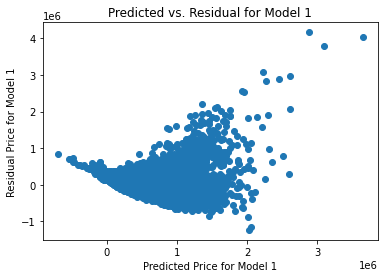

In [76]:
# predicted vs. residual
preds1 = model1.predict(x1)
resids1 = y1 - preds1

plt.plot(preds1, resids1, "o")
plt.xlabel('Predicted Price for Model 1')
plt.ylabel('Residual Price for Model 1')
plt.title('Predicted vs. Residual for Model 1');

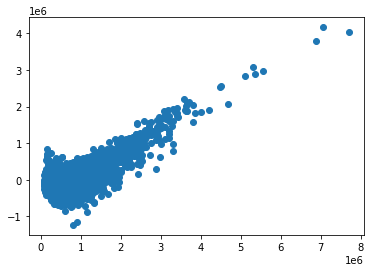

In [77]:
# checking for independence and homoskedasticity
# independence appears linear, and higher values do appear homoskedastic
fig, ax = plt.subplots()
ax.scatter(y1, resids1);

In [78]:
# ideal Durbin-Watson is 2 for independence 
model1.summary().tables[2]

Omnibus:,17379.730,Durbin-Watson:,2.003
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1252513.270
Skew:,3.474,Prob(JB):,0.00
Kurtosis:,40.018,Cond. No.,7.58


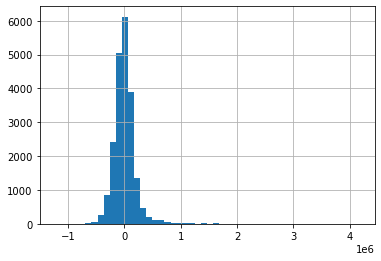

In [79]:
# creating histogram of residuals (errors) to check if errors are 
# normally distributed, which it appears to be

resids1.hist(bins=50);

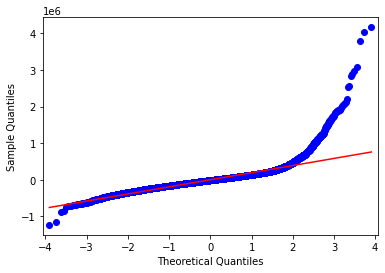

In [80]:
# QQ plot is another means for assessing for normality of errors
# Again, we note the errors follow the line closely until the end 
sm.qqplot(resids1, line='r');

In [81]:
# Jarque-Bera is slightly reduced, and prob(JB) still < 0.05
# The Omnibus number, Skew & Kurtosis are about the same
# Condition number already appears in a safe range, and therefore
# we do not appear to have a significant amount of multicollinearity 
# between the features
model1.summary().tables[2]

Omnibus:,17379.730,Durbin-Watson:,2.003
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1252513.270
Skew:,3.474,Prob(JB):,0.00
Kurtosis:,40.018,Cond. No.,7.58


## Repeat assessment with lower price dataframe (df10)

In [82]:
df10.shape

(20706, 14)

In [83]:
df10.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


In [84]:
df10drop = df10.drop(['id', 'price'], axis=1)

In [85]:
ss_df10 = StandardScaler().fit(df10drop)
df10_scaled = ss_df10.transform(df10drop)

In [86]:
df10_scaled = pd.DataFrame(df10_scaled, columns=df10drop.columns)

In [87]:
x2 = sm.add_constant(df10_scaled)
y2 = df10['price'].reset_index(drop=True)

In [88]:
model2 = sm.OLS(endog=y2, exog=x2).fit()

In [89]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3362.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:48:45   Log-Likelihood:            -2.7553e+05
No. Observations:               20706   AIC:                         5.511e+05
Df Residuals:                   20693   BIC:                         5.512e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.009e+05   1011.174    495.326      0.000    4.99e+05    5.03e+05
bedrooms      -2.566e+04   1311.452    -19.565      0.000   -2.82e+04   -2.31e+04
bathrooms      2.849e+04   1773.811     16.063      0.000     2.5e+04     3.2e+04
sqft_living    9.376e+04   2725.026     34.408      0.000    8.84e+04    9.91e+04
sqft_lot       7670.4402   1202.612      6.378      0.000    5313.225       1e+04
floors         1.154e+04   1475.058      7.823      0.000    8647.651    1.44e+04
sqft_above     3.127e+04   2510.231     12.458      0.000    2.64e+04    3.62e+04
yr_built      -2.544e+04   1484.375    -17.141      0.000   -2.84e+04   -2.25e+04
sqft_living15  7.123e+04   1627.981     43.751      0.000     6.8e+04    7.44e+04
sqft_lot15     8397.7112   1308.709      6.417      0.000    5832.539     1.1e+04
time_stamp     8639.3306   1014.388      8.517      0.000    6651.051    1.06e+04
dist_Seattle  -1.059e+05   1238.337    -85.551      0.000   -1.08e+05   -1.04e+05
ord_cond        2.04e+04   1107.012     18.425      0.000    1.82e+04    2.26e+04
==============================================================================
Omnibus:                     3112.488   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7792.525
Skew:                           0.849   Prob(JB):                         0.00
Kurtosis:                       5.480   Cond. No.                         7.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking assumptions

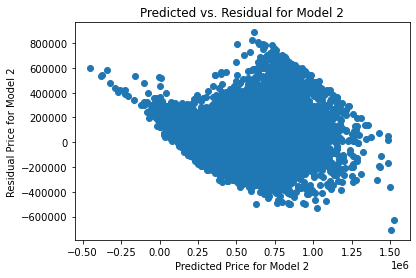

In [90]:
# predicted vs. residual
preds2 = model2.predict(x2)
resids2 = y2 - preds2

plt.plot(preds2, resids2, "o")
plt.xlabel('Predicted Price for Model 2')
plt.ylabel('Residual Price for Model 2')
plt.title('Predicted vs. Residual for Model 2');

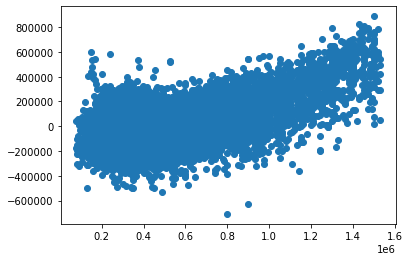

In [91]:
# checking for independence and homoskedasticity
# independence appears linear, and higher values do appear homoskedastic
fig, ax = plt.subplots()
ax.scatter(y2, resids2);

In [92]:
# ideal Durbin-Watson is 2 for independence 
model2.summary().tables[2]

Omnibus:,3112.488,Durbin-Watson:,2.011
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7792.525
Skew:,0.849,Prob(JB):,0.00
Kurtosis:,5.480,Cond. No.,7.23


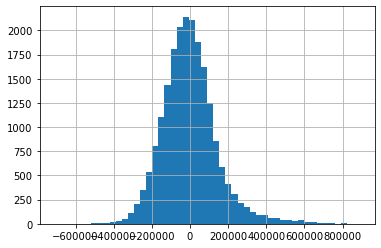

In [93]:
# creating histogram of residuals (errors) to check if errors are 
# normally distributed, which it appears to be

resids2.hist(bins=50);

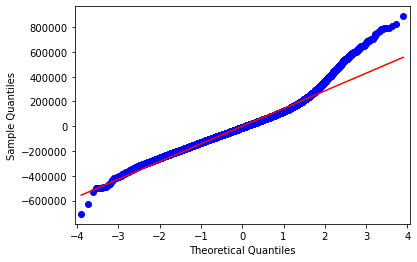

In [94]:
# QQ plot is another means for assessing for normality of errors
# This time we note the errors follow the line more closely  
sm.qqplot(resids2, line='r');

In [95]:
# Jarque-Bera is much lower, though prob(JB) still < 0.05
# The Omnibus number, Skew & Kurtosis are much lower as well
# Condition number already appears in a safe range, and therefore
# we do not appear to have a significant amount of multicollinearity 
# between the features
model2.summary().tables[2]

Omnibus:,3112.488,Durbin-Watson:,2.011
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7792.525
Skew:,0.849,Prob(JB):,0.00
Kurtosis:,5.480,Cond. No.,7.23


In [96]:
# For a recap and comparison to the prior models, please see below

In [97]:
print(model0.summary().tables[2], model1.summary().tables[2], model2.summary().tables[2])

Omnibus:                    17883.052   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1336079.612
Skew:                           3.517   Prob(JB):                         0.00
Kurtosis:                      40.885   Cond. No.                         7.61
============================================================================== ==============================================================================
Omnibus:                    17379.730   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1252513.270
Skew:                           3.474   Prob(JB):                         0.00
Kurtosis:                      40.018   Cond. No.                         7.58
============================================================================== ==============================================================================
Omnibus:                     3112.488   Durbin-Watso

# Additional visualizations for presentation

## Actual vs. Predicted

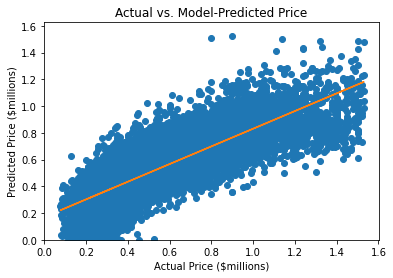

In [98]:
# predicted vs. actual
model2_pred = model2.predict(x2)


y = model2_pred / 1000000
x = df10['price'] / 1000000

plt.plot(x,y, "o")
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Actual Price ($millions)')
plt.ylabel('Predicted Price ($millions)')
plt.title('Actual vs. Model-Predicted Price')
plt.savefig('./images/model_act_pred', bbox_inches='tight', dpi=300);

## Bar plot for explanation of coefficients

In [99]:
x_bar = model2.params.map(abs).sort_values(ascending=False).index[1:13]
print(x_bar)

Index(['dist_Seattle', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'bedrooms', 'yr_built', 'ord_cond', 'floors', 'time_stamp',
       'sqft_lot15', 'sqft_lot'],
      dtype='object')


In [100]:
y_bar= model2.params.map(abs).sort_values(ascending=False)[1:13]
print(y_bar)

dist_Seattle     105941.120889
sqft_living       93763.442475
sqft_living15     71225.923895
sqft_above        31272.243970
bathrooms         28492.048986
bedrooms          25658.076063
yr_built          25444.271392
ord_cond          20397.088474
floors            11538.881107
time_stamp         8639.330580
sqft_lot15         8397.711213
sqft_lot           7670.440235
dtype: float64


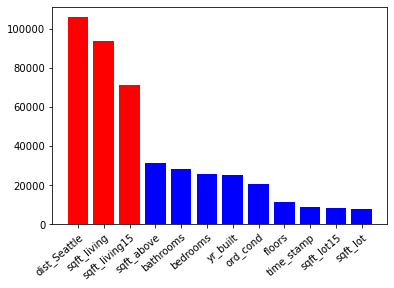

In [101]:
plt.bar(x = x_bar, height = y_bar, color=['red', 'red', 'red', 'blue', 'blue','blue','blue','blue','blue','blue','blue','blue'])
plt.xticks(rotation=40, ha="right", rotation_mode='anchor')
# plt.xlabel('Features')
# plt.ylabel('Absolute change in price ($) per standard deviation of feature')
plt.savefig('./images/coefs', bbox_inches='tight', dpi=300);

## Scatter Plots

### House Price as a function of Area of Living Space

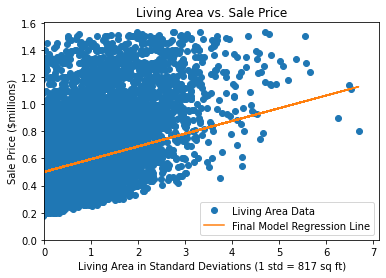

In [102]:
x = df10_scaled['sqft_living']
y = y2 / 1000000
plt.plot(x, y, 'o', alpha=1)
m = model2.params.map(abs).sort_values(ascending=False)[2] / 1000000
b = model2.params.map(abs).sort_values(ascending=False)[0] / 1000000
plt.plot(x, m*x+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Living Area in Standard Deviations (1 std = 817 sq ft)')
plt.ylabel('Sale Price ($millions)')
plt.title('Living Area vs. Sale Price')
plt.legend(['Living Area Data', 'Final Model Regression Line'])
plt.savefig('./images/sqftscatter', bbox_inches='tight', dpi=300);

## House Price as a Function of Distance from Downtown Seattle

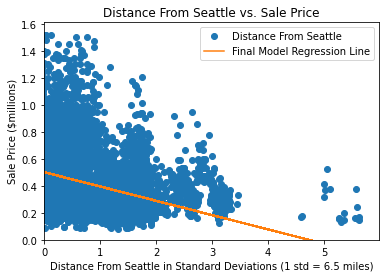

In [103]:
x = df10_scaled['dist_Seattle']
y = y2 / 1000000
plt.plot(x, y, 'o', alpha=1)
m = model2.params.sort_values()[0] / 1000000
b = model2.params.map(abs).sort_values(ascending=False)[0] / 1000000
plt.plot(x, m*x+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Distance From Seattle in Standard Deviations (1 std = 6.5 miles)')
plt.ylabel('Sale Price ($millions)')
plt.title('Distance From Seattle vs. Sale Price')
plt.legend(['Distance From Seattle', 'Final Model Regression Line'])
plt.savefig('./images/dist_scatter', bbox_inches='tight', dpi=300);

## House Price as a Function of Living Space for Closest 15 Neighbors

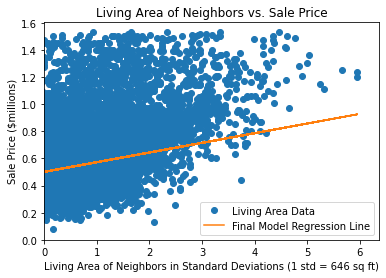

In [104]:
x = df10_scaled['sqft_living15']
y = y2 / 1000000
plt.plot(x, y, 'o', alpha=1)
m = model2.params.map(abs).sort_values(ascending=False)[3] / 1000000
b = model2.params.map(abs).sort_values(ascending=False)[0] / 1000000
plt.plot(x, m*x+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Living Area of Neighbors in Standard Deviations (1 std = 646 sq ft)')
plt.ylabel('Sale Price ($millions)')
plt.title('Living Area of Neighbors vs. Sale Price')
plt.legend(['Living Area Data', 'Final Model Regression Line'])
plt.savefig('./images/sqft15_scatter', bbox_inches='tight', dpi=300);

# Checking date range in data set

In [106]:
pd.to_datetime(df['date']).min()

Timestamp('2014-05-02 00:00:00')

In [107]:
pd.to_datetime(df['date']).max()

Timestamp('2015-05-27 00:00:00')

# Calculating how target feature coefficients translate to dollar amount changes in price

In [108]:
df10.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
count,2.070600e+04,2.070600e+04,20706.000000,20706.000000,20706.000000,2.070600e+04,20706.000000,20706.000000,20706.000000,20706.000000,20706.000000,2.070600e+04,20706.000000,20706.000000
mean,4.637308e+09,5.008605e+05,3.353376,2.078371,2013.098039,1.144596e+04,1.484859,1733.881677,1970.695934,1946.663624,9495.029991,1.414559e+09,11.439822,2.408770
std,2.876835e+09,2.498201e+05,0.895435,0.730366,817.078931,2.536101e+04,0.538833,754.744117,29.377977,645.759565,9404.026156,9.755590e+06,6.511199,0.649193
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,460.000000,651.000000,1.399003e+09,0.717448,0.000000
25%,2.171400e+09,3.182500e+05,3.000000,1.500000,1410.000000,5.000000e+03,1.000000,1180.000000,1951.000000,1470.000000,5029.250000,1.406002e+09,6.136998,2.000000
50%,4.001150e+09,4.447000e+05,3.000000,2.250000,1880.000000,7.497000e+03,1.000000,1530.000000,1974.000000,1810.000000,7500.000000,1.413432e+09,10.314469,2.000000
75%,7.379675e+09,6.250000e+05,4.000000,2.500000,2480.000000,1.020000e+04,2.000000,2140.000000,1996.000000,2310.000000,9794.000000,1.424149e+09,15.558620,3.000000
max,9.900000e+09,1.530000e+06,11.000000,7.500000,7480.000000,1.164794e+06,3.500000,7320.000000,2015.000000,5790.000000,86248.000000,1.432699e+09,48.023035,4.000000


- Average (mean) house, in our model based on y-intercept value (const): $500,900

Other average features to be aware of:
    - bedrooms: 3 (3.35)
    - bathrooms: 2 (2.08)
    - sqft_living: 2,013 sq ft 
    - sqft_lot: 11,450 sq ft
    - floors: 1 (1.48)
    - sqft_above: 1,734 sq ft
    - yr_built: 1970
    - sqft_living15: 1,947 sq ft
    - sqft_lot15: 9,495 sq ft
    - distance from downtown Seattle: 11.44 miles
    - condition: average (2.41 out of 4)

In [109]:
df10['sqft_living'].std()
# coef = 9.364 x 10^4 = $93,640

817.0789310520772

- Housing price increases by $93,640 for every 817 sqft_living increase

In [110]:
df10['sqft_living15'].std()
# coef = 7.106 x 10^4 = $71,060

645.7595647094573

- Housing price increases by $71,060 for every 646 sqft_living15 increase

In [111]:
df10['dist_Seattle'].std()
# coef = - 1.057 x 10^5 = (-)$105,700

6.511199267844617

- Housing price *decreases* by $105,700 for every 6.5 miles away from city center